# Ising model
> a mathematical model for phase transitions



## About

This blog is about the Ising model. The Ising model plays a central role in the theory of phase transitions. It is a mathematical model of ferromagnetism (for example, iron can be magnetized in a magnetic field, but if heated, it loses magnetization beyond Curie temperature). This blog contains Python code and a detailed algorithm for the [Monte Carlo simulation of the Ising model](#MC_Ising).  

The Ising model is named after Ernst Ising, Ph.D. in Physics (1924) from the University of Hamburg under the supervision of Wilhelm Lenz. Ising solved the one-dimensional (1D) Ising model exactly to find no phase transition. He also provided arguments on why there would not be a phase transition in higher dimensions either. In 1936, Peierls argued that both 2D and 3D Ising models admit phase transitions. The argument is summarised [in the second half of the blog](#another_cell)

The Ising Hamiltonian can be written as,

$$
\mathcal{H} = -J \sum_{\langle i j \rangle} \sigma_{i} \sigma_{j}.  
$$

* The spins $\sigma_{i}$ can take values $\pm 1$,
*  $\langle i j \rangle$ implies nearest-neighbor interaction only,
* $J>0$ is the strength of exchange interaction.


The system undergoes a second order phase transition at the critical temperature $T_{c}$. For temperatures less than $T_{c}$, the system magnetizes, and the state is called the ferromagnetic or the ordered state. This amounts to a globally ordered state due to the presence of local interactions between the spin. For temperatures greater than $T_{c}$, the system is in the disordered or the paramagnetic state. In this case, there are no long-range correlations between the spins.

The order parameter

$$ m = \frac{1}{N}\sum_i \sigma_i $$

for this system is the average magnetization. The order parameter distinguishes the two phases realized by the systems. It is zero in the disordered state, while non-zero in the ordered, ferromagnetic, state.




<a id='another_cell'></a>
##  Peierls argument

The one dimensional (1D) Ising model does not exhibit the phenomenon of phase transition while higher dimensions do. This can be argued based on arguments, due to Peierls, related to the net change in free energy, $F = E-TS$. Here $E$ and $S$ are, respectively, the energy and entropy of the system. We estimate the net change in free energy for introducing a disorder in an otherwise ordered system. The ordered state can only be stable if the net change in free energy is positive, $\Delta F>0$, for any non-zero temperature.  

**1D Ising model**: Introducing a domain wall (defect) in an ordered state increases the energy by $4J$, while the entropy change is $k_B \ln N$, due to $N$ choices to introduce the domain. So net change in the free energy, $\Delta F = 4J - k_BT \ln N $, is always negative for $N\rightarrow\infty$. Thus, the system prefers a disordered state. So, there is no spontaneous symmetry breaking in 1D for an infinite Ising chain. This argument can be generalized for any domain of length $L$ and higher dimensions.

**2D Ising model**: For two and higher dimensions, we can introduce islands of defects, which cost only at the boundaries, and are thus, proportional to the perimeter $L=\varepsilon N^2$, where $0<\varepsilon<1$. In 2D, the number of islands scale as $3^{\varepsilon N^2}$, while $\Delta E = \varepsilon 4JN^2$. $\Delta F$ is then $\varepsilon 4JN^2 - k_BT \ln (N^{2}3^{\varepsilon N^2})$. This gives a rough estimate of the critical temperature $T_{c} \sim J/k_B$.  

<a id='MC_Ising'></a>
## Monte Carlo simulation of 2D Ising model
The following code simulates the Ising model in 2D using the Metropolis algorithm. The main steps of Metropolis algorithm are:

1. Prepare an initial configuration of N spins
2. Flip the spin of a randomly chosen lattice site.
3. Calculate the change in energy dE.
4. If dE < 0, accept the move. Otherwise accept the move with probability exp^{-dE/T}. This satisfies the detailed balance condition, ensuring a final equilibrium state.
5. Repeat 2-4.

In the code below, we have estimated and plotted energy, magnetization, specific heat and susceptibility of the system.

In [ ]:
## import standard libraries for scientific computations

import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy.sparse import spdiags,linalg,eye
from numba import jit
from tqdm import trange


In [ ]:
#----------------------------------------------------------------------
##  BLOCK OF FUNCTIONS USED IN THE MAIN CODE
#----------------------------------------------------------------------



def initialstate(N):
    '''
    Generates a random spin configuration for initial condition
    '''
    state = 2*np.random.randint(2, size=(N,N))-1
    return state


@jit(nopython=False)
def mcmove(config, beta):
    '''
    Monte Carlo move using Metropolis algorithm
    '''

    for i in range(N):
        for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                cost = 2*s*nb

                if cost < 0:
                    s *= -1
                elif rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config


@jit(nopython=False)
def calcEnergy(config):
    '''
    Energy of a given configuration
    '''
    energy = 0

    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/2.  # to compensate for over-counting


def calcMag(config):
    '''
    Magnetization of a given configuration
    '''
    mag = np.sum(config)
    return mag

In [ ]:
#----------------------------------------------------------------------
## NOTE: change these parameters for a smaller and faster simulation
#----------------------------------------------------------------------


nt      = 2**8          #  number of temperature points
N       = 2**4          #  size of the lattice, N x N
eqSteps = 2**10        #  number of MC sweeps for equilibration
mcSteps = 2**11       #  number of MC sweeps for calculation


T       = np.linspace(1.53, 3.28, nt);
E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N)
# divide by number of samples, and by system size to get intensive values

In [ ]:
#----------------------------------------------------------------------
#  MAIN PART OF THE CODE
#----------------------------------------------------------------------

for tt in trange(nt):
    config = initialstate(N)         # initialise

    E1 = M1 = E2 = M2 = 0
    iT=1.0/T[tt]; iT2=iT*iT;

    for i in range(eqSteps):         # equilibrate
        mcmove(config, iT)           # Monte Carlo moves

    for i in range(mcSteps):
        mcmove(config, iT)
        Ene = calcEnergy(config)     # calculate the energy
        Mag = calcMag(config)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag
        E2 = E2 + Ene*Ene


    # divide by number of sites and iteractions to obtain intensive values
    E[tt] = n1*E1
    M[tt] = n1*M1
    C[tt] = (n1*E2 - n2*E1*E1)*iT2
    X[tt] = (n1*M2 - n2*M1*M1)*iT

100%|█████████████████████████████████████████| 256/256 [00:05<00:00, 50.00it/s]


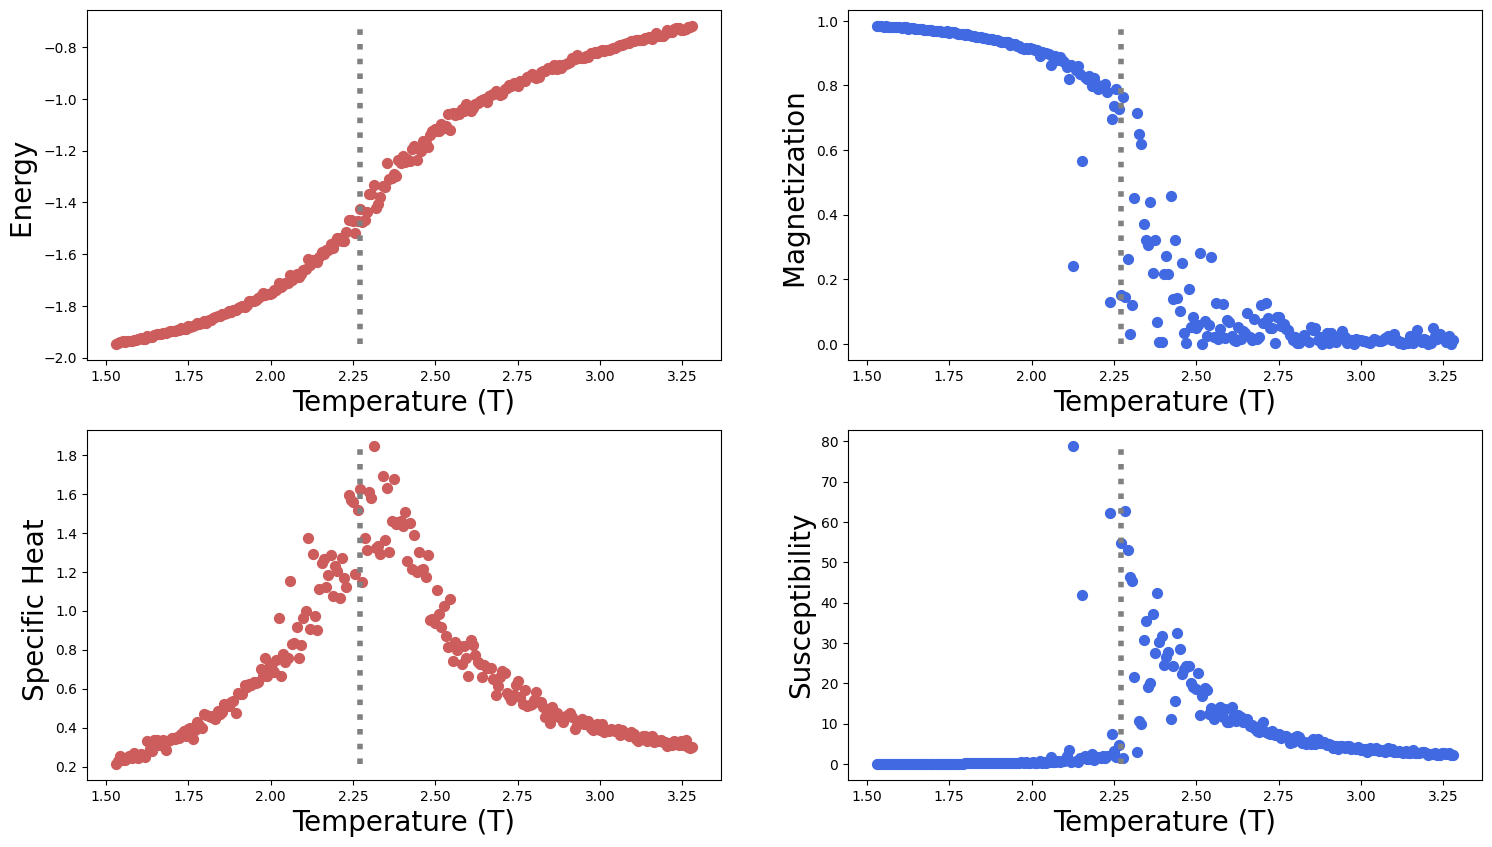

In [ ]:
#----------------------------------------------------------------------
#  plot the calculated values
#----------------------------------------------------------------------

f = plt.figure(figsize=(18, 10)); #


sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.plot(T*0+2.27, np.linspace(np.min(E), np.max((E)), np.size(T)), ':', lw=4, c='gray')

plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');


sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, abs(M), s=50, marker='o', color='RoyalBlue')
plt.plot(T*0+2.27, np.linspace(0, np.max(abs(M)), np.size(T)), ':', lw=4, c='gray')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');


sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');
plt.plot(T*0+2.27, np.linspace(np.min(C), np.max((C)), np.size(T)), ':', lw=4, c='gray')


sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.plot(T*0+2.27, np.linspace(np.min(X), np.max((X)), np.size(T)), ':', lw=4, c='gray')

plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');

The quantities on the y-axis, in the above plots, are per spin. These intensive quantities have been plotted against temperature on the x-axis. It can be seen that the critical temperature for the numerical simulation of this small system is close to the known value of $T_c\sim2.269$ for a thermodynamic system.

**Note:** A better optimized version of the above code can be found [here](https://github.com/rajeshrinet/compPhy/tree/master/ising/). One of the difference being that we do not calculate the exponential in the loop in the optimized cython version. Thus, avoiding $N^2$ calls to a special function. We can do thisas the spins only take values 1 and -1. Thus, there are only two possibilities for an energy increasing move. They are:

In [ ]:
# change in energy is 8J
#    d          d               u          u
# d  d  d => d  u  d   or    u  u  u => u  d  u
#    d          d               u          u
#
# change in energy is 4J
#    d          d               u          u
# d  d  u => d  u  u   or    u  u  d => u  d  d
#    d          d               u          u
#
# Here u and d are used for up and down configuration of the spins

## Snapshots of the configurations

We start with a random initial condition and then plot the instantaneous configurations, as the system [coarsens](https://speakerdeck.com/rajeshrinet/coarsening-phenomena) to its equilibrium state.

In [ ]:
%matplotlib inline
# Simulating the Ising model


class Ising():
    ''' Simulating the Ising model '''


    ## monte carlo moves
    def mcmove(self, config, N, beta):
        ''' This is to execute the monte carlo moves using
        Metropolis algorithm such that detailed
        balance condition is satisified'''
        for i in range(N):
            for j in range(N):
                    a = np.random.randint(0, N)
                    b = np.random.randint(0, N)
                    s =  config[a, b]
                    nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                    cost = 2*s*nb
                    if cost < 0:
                        s *= -1
                    elif rand() < np.exp(-cost*beta):
                        s *= -1
                    config[a, b] = s
        return config



    def simulate(self):
        ''' This module simulates the Ising model'''
        N, temp     = 64, .4        # Initialse the lattice
        config = 2*np.random.randint(2, size=(N,N))-1
        f = plt.figure(figsize=(15, 15), dpi=80);
        self.configPlot(f, config, 0, N, 1);

        msrmnt = 1001
        for i in trange(msrmnt):
            self.mcmove(config, N, 1.0/temp)
            if i == 1:       self.configPlot(f, config, i, N, 2);
            if i == 4:       self.configPlot(f, config, i, N, 3);
            if i == 32:      self.configPlot(f, config, i, N, 4);
            if i == 100:     self.configPlot(f, config, i, N, 5);
            if i == 1000:    self.configPlot(f, config, i, N, 6);


    def configPlot(self, f, config, i, N, n_):
        ''' This modules plts the configuration once passed to it along with time etc '''
        X, Y = np.meshgrid(range(N), range(N))
        sp =  f.add_subplot(3, 3, n_ )
        plt.setp(sp.get_yticklabels(), visible=False)
        plt.setp(sp.get_xticklabels(), visible=False)
        plt.pcolormesh(X, Y, config, cmap=plt.cm.viridis);
        plt.title('Time=%d'%i); plt.axis('tight')
    plt.show()

100%|███████████████████████████████████████| 1001/1001 [00:18<00:00, 54.76it/s]


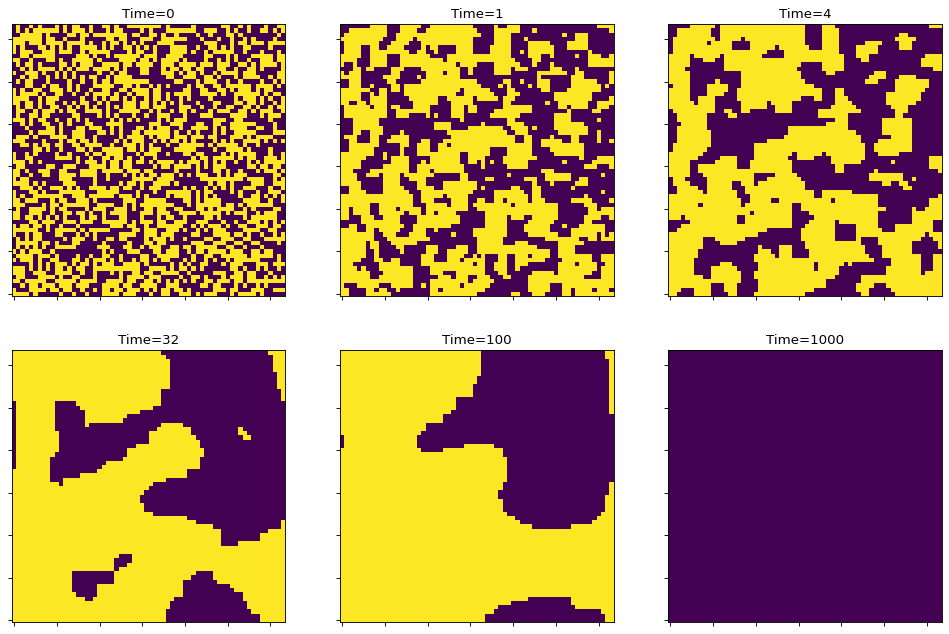

In [ ]:
rm = Ising()
rm.simulate()